# Creating Synthetic Solar Time Series

PowNet is designed to work with time series data, facilitating seamless sensitivity analysis within its modeling framework. This example demonstrates how to generate multiple synthetic hourly solar time series (5 scenarios) using PowNet's time series capabilities. The original time series is an estimated one of a large solar farm ("EASNS") found in the 2023 Thai power system. Data files for this case study, called "synthetic_timeseries", can be found [here](https://github.com/Critical-Infrastructure-Systems-Lab/PowNet/tree/master/model_library). Please download them to a folder on your local machine.

**Note:** PowNet requires the `pmdarima` package for advanced time series analysis. Ensure it is installed in your environment. This package is not included as a dependency in PowNet by default.

- If you use Conda, you can install it with: `conda install pmdarima`

- You can also install it with pip: `pip install pmdarima`



## Load Historical Solar time series

We begin by loading the historical hourly data from a CSV file. This data serves as the basis for our time series model. The data is loaded into a pandas DataFrame, and the index is adjusted to start from 1, consistent with PowNet's indexing convention.

In [1]:
import os
import pandas as pd

from pownet.stochastic import SolarTSModel # This is the solar model class
from pownet.data_utils import get_datetime_index

# Must define your own filepath here
solar_filepath = os.path.join("..", "model_library", "synthetic_timeseries", "solar.csv")
solar_timeseries = pd.read_csv(solar_filepath, header=[0, 1])

# In our example CSF file, the column header has two levels (unit and node).
# We only need the unit's name
unit_node_map = solar_timeseries.columns.to_flat_index().to_list()
unit_node_map = {unit: node for unit, node in unit_node_map}
solar_timeseries.columns = solar_timeseries.columns.droplevel(1)

solar_timeseries["datetime"] = get_datetime_index(2023)

## Prepare Data for Time Series Modeling

Modeling the solar time series requires sunset and sunrise hours of each day. We combine this information with the solar time series into a single DataFrame to facilitate time series analysis.

In [2]:
# Need sunrise and sunset hours for the solar model
sun_times = pd.read_csv(
    os.path.join("..", "model_library", "synthetic_timeseries", "thailand_2023_weather.csv"),
    header=0,
    usecols=["sunset", "sunrise"],
)
solar_timeseries["sunrise"] = sun_times["sunrise"]
solar_timeseries["sunset"] = sun_times["sunset"]

solar_timeseries.head()

,EASNS,datetime,sunrise,sunset
0,0.0,2023-01-01 00:00:00,6:00:00,17:00:00
1,0.0,2023-01-01 01:00:00,6:00:00,17:00:00
2,0.0,2023-01-01 02:00:00,6:00:00,17:00:00
3,0.0,2023-01-01 03:00:00,6:00:00,17:00:00
4,0.0,2023-01-01 04:00:00,6:00:00,17:00:00


## Initialize the Solar Time Series Model

The resulting DataFrame is used as input to initialize PowNet's `SolarTSModel` class.

In [3]:
solar_model = SolarTSModel()
solar_model.load_data(solar_timeseries)

## 4. Fit Monthly SARIMAX Models

We now fit a Seasonal Autoregressive Integrated Moving Average with Exogenous Regressors (SARIMAX) model to the prepared time series data. The `fit` method handles the standard time series analysis steps, including potential data transformations (like differencing for stationarity) and fitting the SARIMAX model itself. A separate model is fitted for each month of the year to capture potentially distinct monthly patterns and statistical characteristics.

The key parameters specified for the SARIMAX model are:

* `target_column`: The variable we aim to model ('EASNS').
* `arima_order`: The non-seasonal (p, d, q) order of the ARIMA component, defining the autoregressive, differencing, and moving average terms.
* `seasonal_order`: The seasonal (P, D, Q, s) order. Here, 's' would represent the seasonal period (e.g., 24 for daily seasonality). This specific example does not include a seasonal component in the model configuration.

You might encounter maximum likelihood warnings indicating that the optimization process failed to converge perfectly. This suggests the resulting model parameters might be slightly sub-optimal. However, if the generated synthetic time series still exhibit statistical properties suitable for your analysis, these warnings may not be critical. It is always recommended to visually inspect and statistically evaluate the generated time series to ensure they meet your requirements.

*Fitting the models can take some time, depending on the data volume and the chosen model complexity.*

In [4]:
num_scenarios = 5
solar_unit = "EASNS"
scenarios = pd.DataFrame(
    pd.NA, index=solar_timeseries.index, columns=range(1, num_scenarios + 1)
)

solar_model.fit(target_column=solar_unit, arima_order=(2, 1, 2))

c:\Users\phumt\anaconda3\envs\pownet\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\phumt\anaconda3\envs\pownet\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\phumt\anaconda3\envs\pownet\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\phumt\anaconda3\envs\pownet\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive par

## Analyze Model Residuals

After fitting the model, it's good practice to examine the residuals (the difference between the actual values and the model's predictions). Ideally, the residuals should resemble independent and identically distributed (i.i.d.) white noise, indicating that the model has captured the underlying patterns in the data well. The `plot_residuals` method helps visualize the distribution and autocorrelation of the residuals.

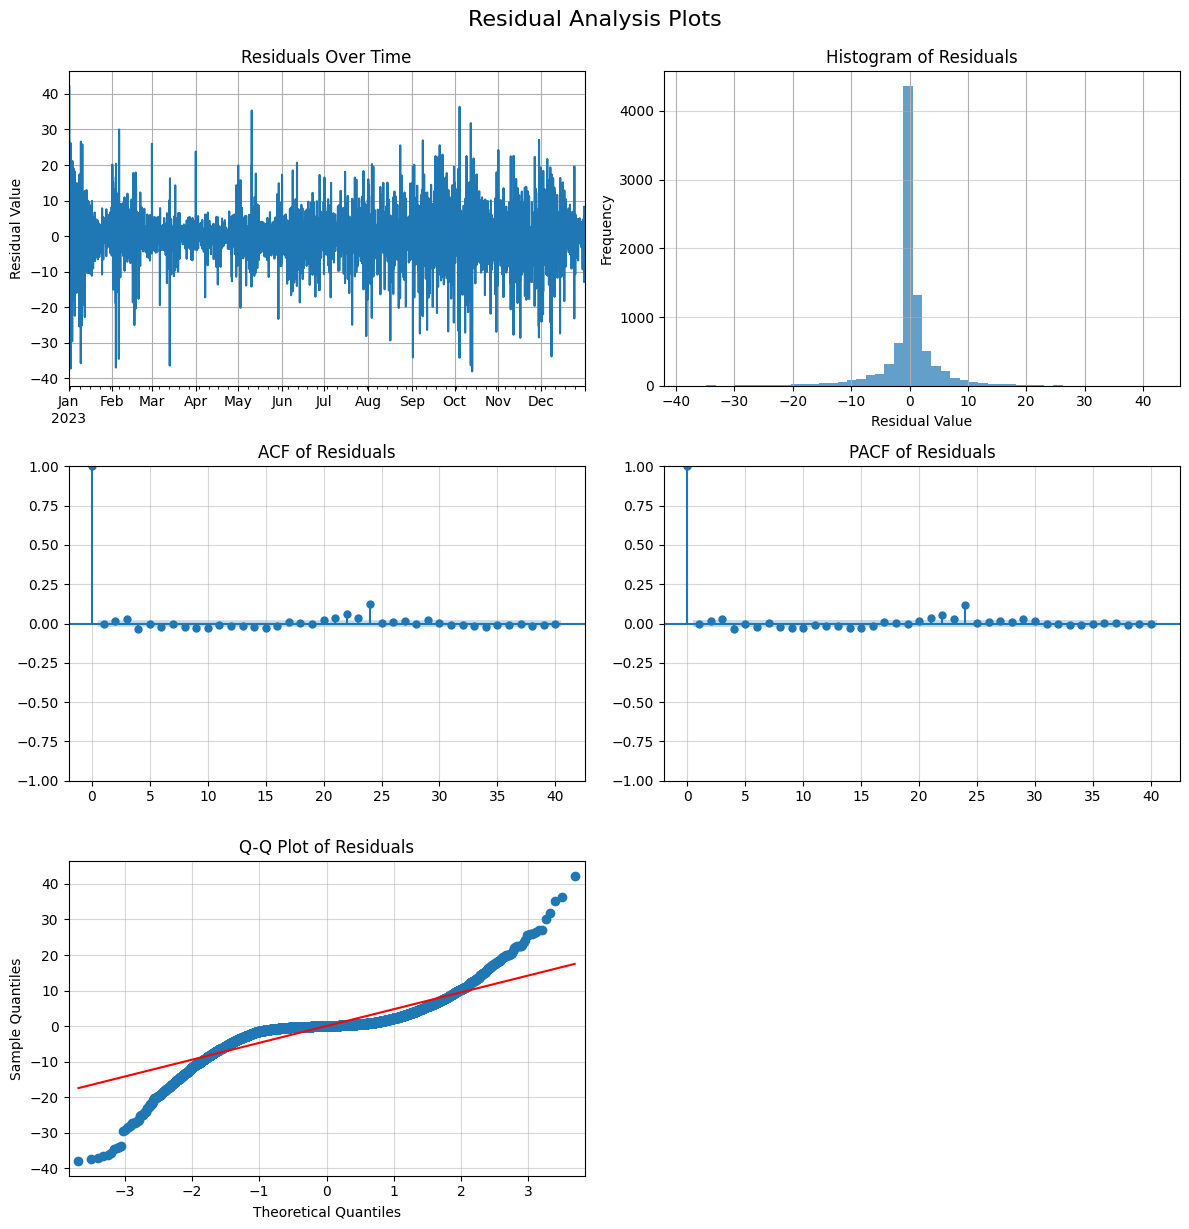

In [5]:
solar_model.plot_residuals(bins=50)

## Generate Synthetic Time Series

Once satisfied with the fitted time series model, we can use it to generate synthetic solar time series. We specify the desired number of scenarios (`num_scenarios`). For each scenario, the `get_synthetic` method simulates a new time series based on the fitted SARIMAX model. The generated scenarios capture the stochastic nature and patterns learned from the historical data, sharing the same statistical characteristics.

In [6]:
for scenario_id in range(1, num_scenarios + 1):
    temp_series = solar_model.get_synthetic().reset_index(drop=True)
    temp_series.index += 1  # indexing starts at 1
    scenarios[scenario_id] = temp_series

## Visualize Synthetic Scenarios

Finally, we plot the generated synthetic time series scenarios, focusing on a shorter period (like the first 7 days) for better visualization, to compare their behavior and variability against each other and potentially the original data.

<Axes: title={'center': 'Synthetic Solar Scenarios'}, xlabel='hour', ylabel='Solar availability (MW)'>

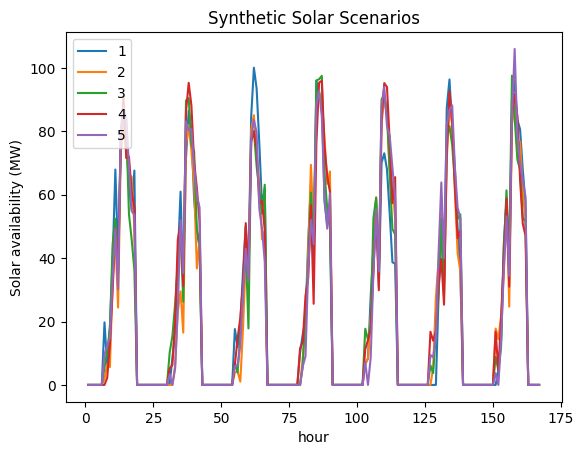

In [7]:
scenarios.head(24*7).plot(xlabel="hour", ylabel="Solar availability (MW)", title="Synthetic Solar Scenarios")